In [29]:
# imports
import numpy as np
from math import comb, exp
from functools import lru_cache
import time
try:
    from tqdm import tqdm
    use_tqdm = True
except:
    use_tqdm = False
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm
import os
# import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [30]:
"""
ntg_part1.py
Part 1 for reproducing:
  - payoff functions π_I, π_T, π_U
  - hypergeometric group sampling probability
  - expected payoffs f_I, f_T, f_U (finite X)
  - mutation-selection imitation probability T_{A->B} (eq. 2.1)

Formulas taken from the manuscript (payoffs, hypergeometric probability, eq.2.1).
Cite: Liu et al., rsif-2024-0726.R1_Proof_hi.pdf (uploaded).
"""


# -------------------------
# Utility: safe comb and hypergeometric probability
# -------------------------
@lru_cache(maxsize=None)
def nCr(n, r):
    if r < 0 or r > n:
        return 0
    return comb(n, r)

def hypergeom_prob(X_minus1, count_I_pool, count_T_pool, draws_N_minus1, NI, NT):
    """
    P(X-1, iI-1, iT, N-1, NI, NT) from the paper
    where:
      - X_minus1 = X - 1
      - count_I_pool = iI - 1  (for focal investor) OR iI (for other payoff calc)
      - count_T_pool = iT      (depending on focal)
      - draws_N_minus1 = N - 1
      - NI, NT are counts drawn from those pools (nonnegative ints)
    formula:
      C(count_I_pool, NI) * C(count_T_pool, NT) * C(X - iI - iT, draws_N_minus1 - NI - NT)
      -------------------------------------------------------------------------------
                              C(X_minus1, draws_N_minus1)
    """
    numerator = nCr(count_I_pool, NI) * nCr(count_T_pool, NT) * nCr(
        X_minus1 - count_I_pool - count_T_pool, draws_N_minus1 - NI - NT
    )
    denom = nCr(X_minus1, draws_N_minus1)
    if denom == 0:
        return 0.0
    return numerator / denom

# -------------------------
# Model payoff functions πI, πT, πU
# (these match Eqns in the paper; OT(NT) and OU(NT) defined by alpha, M)
# -------------------------
def OT(NT, alpha, M):
    # reward factor function O_T(NT) from manuscript
    # OT(NT) = 1 - alpha  if NT + 1 < M
    #         = alpha      if NT + 1 >= M
    return (1 - alpha) if (NT + 1 < M) else alpha

def OU(NT, alpha, M):
    # punishment factor O_U(NT)
    # OU(NT) = -alpha     if NT < M
    #        = alpha - 1  if NT >= M
    return (-alpha) if (NT < M) else (alpha - 1)

def payoff_pi_I(NI, NT, NU, params):
    """
    pi_I:
      - if NI == N-1: payoff = -delta
      - else: payoff = (RT*NT/(N-1-NI) * tv) - tv - delta  [careful with indices]
    Note: the paper uses expression RT * NT / (NT+NU+1) * tv returned to each investor.
    But in the πI formula the factor shown maps to RT*NT/(N-1-NI) in the snippet; to match paper
    we implement according to the expression in the PDF:
       πI = -δ  if NI == N-1
       otherwise: (RT * NT / (N - 1 - NI)) * tv - tv - δ
    """
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    if NI == N - 1:
        return - delta
    denom = (N - 1 - NI)
    # Avoid division by zero (should be protected by NI != N-1)
    return (RT * NT / denom) * tv - tv - delta

def payoff_pi_T(NI, NT, NU, params):
    """
    πT:
      - if NI == 0: payoff = -delta (no investors to get returns)
      - else: RT * NI / (N - NI) * tv - delta + N*delta/(NT+1) * OT(NT)
    Implementation follows the formula snippet in the PDF.
    """
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    # N*delta/(NT + 1) * OT(NT)
    incentive_term = (N * delta) / (NT + 1) * OT(NT, alpha, M)
    return (RT * NI / denom) * tv - delta + incentive_term

def payoff_pi_U(NI, NT, NU, params):
    """
    πU:
      - if NI == 0: payoff = -delta
      - else: RU * NI / (N - NI) * tv - delta + N*delta/(NU+1) * OU(NT)
    Note: OU depends on NT (the number of trustworthy trustees).
    """
    RU = params['RU']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    incentive_term = (N * delta) / (NU + 1) * OU(NT, alpha, M)
    return (RU * NI / denom) * tv - delta + incentive_term

# -------------------------
# Expected payoffs fI, fT, fU (sum over NI, NT using hypergeometric)
# fI uses P(X-1, iI-1, iT, N-1, NI, NT)
# fT uses P(X-1, iI, iT-1, N-1, NI, NT)
# fU uses P(X-1, iI, iT, N-1, NI, NT)
# -------------------------
def expected_payoffs(iI, iT, X, params):
    """
    Compute (fI, fT, fU) for population state counts (iI, iT, iU = X - iI - iT)
    Returns tuple of floats (fI, fT, fU).
    """
    N = params['N']
    iU = X - iI - iT
    Xm1 = X - 1
    draws = N - 1

    fI = 0.0
    fT = 0.0
    fU = 0.0

    # NI runs 0..N-1, NT runs 0..N-1-NI
    for NI in range(0, draws + 1):
        for NT in range(0, draws - NI + 1):
            NU = draws - NI - NT
            # probabilities depend on focal type (counts in pool differ)
            p_I = hypergeom_prob(Xm1, iI - 1, iT, draws, NI, NT)  # for focal investor
            p_T = hypergeom_prob(Xm1, iI, iT - 1, draws, NI, NT)  # for focal trustworthy trustee
            p_U = hypergeom_prob(Xm1, iI, iT, draws, NI, NT)      # for focal untrustworthy trustee

            # compute payoffs for that group composition
            pi_I = payoff_pi_I(NI, NT, NU, params)
            pi_T = payoff_pi_T(NI, NT, NU, params)
            pi_U = payoff_pi_U(NI, NT, NU, params)

            fI += p_I * pi_I
            fT += p_T * pi_T
            fU += p_U * pi_U

    return fI, fT, fU

# -------------------------
# Mutation-selection imitation probability T_{A -> B} (eq. 2.1 in paper)
# TA->B = (1 - mu) * [ iA/X * iB/(X-1) * 1/(1+exp(-omega*(fB - fA))) ] + mu * iA/(2X)
# Note: paper's exact arrangement of factors uses iA/X and iB/(X-1) prefactors (we follow that)
# -------------------------
def T_A_to_B(iA, iB, X, fA, fB, mu, omega):
    """
    Compute probability that a participant who chooses A adopts B.
    """
    # avoid division by zero
    if X <= 1:
        return 0.0
    imitation = 0.0
    if X - 1 > 0:
        imitation = (iA / X) * (iB / (X - 1)) * (1.0 / (1.0 + np.exp(-omega * (fB - fA))))
    result = (1.0 - mu) * imitation + mu * (iA / (2.0 * X))
    return float(result)

# -------------------------
# Quick demonstration using default parameters from the paper figures:
# X=100, N=6, RU=6, RT=4, tv=1, mu=0.01, omega=10, delta variable, alpha, M
# -------------------------
if __name__ == "__main__":
    # default params (example)
    params = {
        'RT': 4.0,
        'RU': 6.0,
        'N' : 6,
        'tv': 1.0,
        'delta': 0.25,   # example
        'alpha': 0.0,    # pure reward example
        'M': 3          # threshold example
    }
    X = 100 # note: this param dictates the resolution of the computation, the higher the longer to run (default 100)
    # example population state: iI=2 investors, iT=10 trustworthy, remainder untrustworthy
    iI_example = 2
    iT_example = 10

    fI, fT, fU = expected_payoffs(iI_example, iT_example, X, params)
    print("Expected payoffs (fI, fT, fU) at state (iI={}, iT={}):".format(iI_example, iT_example))
    print(fI, fT, fU)

    # Example of computing T_{I->T} where we pick fI,fT and counts:
    mu = 0.01; omega = 10.0
    iA = iI_example
    iB = iT_example
    t_I_to_T = T_A_to_B(iA, iB, X, fI, fT, mu, omega)
    print("T_{I->T} =", t_I_to_T)


Expected payoffs (fI, fT, fU) at state (iI=2, iT=10):
-0.8418367346938774 -0.04718211212862792 -0.12778129552023051
T_{I->T} = 0.0020992924858048113


In [54]:
# ntg_part2_compute.py
# Part 2: build transition matrix P, compute stationary distribution (power iteration),
# compute mean frequencies and gradient-of-selection, save outputs to results_part2.npz.
#
# Requires: numpy, optionally tqdm for progress bar (pip install tqdm).
# If you already have Part 1 as a module, you can import expected_payoffs, T_A_to_B, etc.
# This file includes the functions from Part 1 for self-containment.

# -------------------------
# Build state list and index mapping
# states are (iI, iT) with iI >=0, iT >=0 and iI + iT <= X
# total_states = (X+1)(X+2)/2
# -------------------------
def enumerate_states(X):
    states = []
    for iI in range(0, X+1):
        for iT in range(0, X+1 - iI):
            states.append((iI, iT))
    index_of = {s: idx for idx, s in enumerate(states)}
    return states, index_of

# -------------------------
# Build transition matrix P (dense). For each state (iI,iT), compute outgoing probabilities:
# TU->I (iI+1, iT), TI->U (iI-1, iT), TU->T (iI, iT+1), TT->U (iI, iT-1),
# TI->T (iI-1, iT+1), TT->I (iI+1, iT-1)
# (only if resulting indices valid). Self-loop = 1 - sum(outgoing)
# -------------------------
def build_transition_matrix(X, params, mu, omega, show_progress=True):
    states, index_of = enumerate_states(X)
    S = len(states)
    P = np.zeros((S, S), dtype=np.float64)

    # We'll cache expected payoffs for each state
    if use_tqdm and show_progress:
        iterator = tqdm(states, desc="Building P")
    else:
        iterator = states

    for s in iterator:
        iI, iT = s
        idx = index_of[s]
        iU = X - iI - iT

        # compute expected payoffs once per state
        fI, fT, fU = expected_payoffs(iI, iT, X, params)

        # compute all TA->B probabilities (use counts for A and B in current state)
        # note: make sure iA and iB correspond to counts in the current state
        # (for I->T: focal is I, role model is T)
        T_I_to_T = T_A_to_B(iI, iT, X, fI, fT, mu, omega)
        T_I_to_U = T_A_to_B(iI, iU, X, fI, fU, mu, omega)

        T_T_to_I = T_A_to_B(iT, iI, X, fT, fI, mu, omega)
        T_T_to_U = T_A_to_B(iT, iU, X, fT, fU, mu, omega)

        T_U_to_I = T_A_to_B(iU, iI, X, fU, fI, mu, omega)
        T_U_to_T = T_A_to_B(iU, iT, X, fU, fT, mu, omega)

        # now map these to adjacent state transitions (check validity)
        total_out = 0.0

        # TU -> I : U becomes I -> (iI+1, iT)
        if iU >= 1 and iI + 1 <= X:
            s2 = (iI + 1, iT)
            P[idx, index_of[s2]] += T_U_to_I
            total_out += T_U_to_I

        # TI -> U : I becomes U -> (iI-1, iT)  (I->U)
        if iI >= 1 and iI - 1 >= 0:
            s2 = (iI - 1, iT)
            P[idx, index_of[s2]] += T_I_to_U
            total_out += T_I_to_U

        # TU -> T : U becomes T -> (iI, iT+1)
        if iU >= 1 and iT + 1 <= X:
            s2 = (iI, iT + 1)
            P[idx, index_of[s2]] += T_U_to_T
            total_out += T_U_to_T

        # TT -> U : T becomes U -> (iI, iT-1)
        if iT >= 1 and iT - 1 >= 0:
            s2 = (iI, iT - 1)
            P[idx, index_of[s2]] += T_T_to_U
            total_out += T_T_to_U

        # TI -> T : I becomes T -> (iI -1, iT +1)
        if iI >= 1 and (iI - 1) + (iT + 1) <= X:
            s2 = (iI - 1, iT + 1)
            P[idx, index_of[s2]] += T_I_to_T
            total_out += T_I_to_T

        # TT -> I : T becomes I -> (iI +1, iT -1)
        if iT >= 1 and (iI + 1) + (iT - 1) <= X:
            s2 = (iI + 1, iT - 1)
            P[idx, index_of[s2]] += T_T_to_I
            total_out += T_T_to_I

        # self-loop probability
        stay = 1.0 - total_out
        # numerical guard
        if stay < 0:
            # tiny negative due to rounding; clamp
            if stay > -1e-12:
                stay = 0.0
            else:
                # if more negative then warn and renormalize
                print("warning 1")
                # renormalize outgoing by scaling
                if total_out > 0:
                    scale = 1.0 / total_out
                    for j in range(S):
                        if P[idx, j] > 0:
                            P[idx, j] *= scale
                    stay = 0.0
                else:
                    stay = 1.0
        P[idx, idx] += stay

    return P, states, index_of

# -------------------------
# Power iteration to find stationary distribution
# ----------------------
#  default tol=1e-12, max_iter=20000
def find_stationary_dist_power(P, tol=1e-4, max_iter=20000, verbose=False):
    S = P.shape[0]
    # start uniform
    x = np.ones(S, dtype=np.float64) / S
    for it in range(max_iter):
        x_next = x @ P  # row-vector style
        diff = np.linalg.norm(x_next - x, 1)
        x = x_next
        if verbose and (it % 200 == 0):
            print(f"iter {it}, L1 diff = {diff:.3e}")
        if diff < tol:
            if verbose:
                print(f"converged in {it} iterations, diff={diff:.2e}")
            break
    # normalize
    x = x / x.sum()
    return x

# -------------------------
# Compute mean frequencies and gradient-of-selection
# gradient components:
#   Delta_T(state) = P(state -> state with iT+1) - P(state -> state with iT-1)
#   Delta_I(state) = P(state -> state with iI+1) - P(state -> state with iI-1)
# We'll compute these using P entries we constructed.
# -------------------------
def compute_summary_and_gradients(P, states, index_of, X):
    S = len(states)
    # stationary dist computed earlier and passed; but here we only compute gradients and mean freqs given stationary
    # function will compute mean frequencies and gradients given P and states after we compute stationary dist.
    # We'll return arrays: mean_rho (I,T,U), gradient_I, gradient_T
    return None

# -------------------------
# Main runner: build P, compute stationary dist, compute means and gradient arrays, save to file
# -------------------------
def main_compute_and_save(X=100, params=None, mu=0.01, omega=10.0, out_filename="results_part2.npz"):
    if params is None:
        params = {'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':0.25, 'alpha':0.0, 'M':3}
    t0 = time.time()
    P, states, index_of = build_transition_matrix(X, params, mu, omega, show_progress=True)
    t1 = time.time()
    print(f"P built: shape={P.shape}  (took {t1-t0:.1f}s)")

    # stationary dist via power iteration
    x = find_stationary_dist_power(P, verbose=True)
    t2 = time.time()
    print(f"Stationary dist computed (took {t2-t1:.1f}s); sum(x)={x.sum():.12f}")

    # compute mean frequencies
    # For each state s=(iI,iT), frequency of I is iI/X, T is iT/X, U is (X-iI-iT)/X
    freq_I = np.array([s[0]/X for s in states])
    freq_T = np.array([s[1]/X for s in states])
    freq_U = 1.0 - freq_I - freq_T

    mean_rho_I = np.dot(x, freq_I)
    mean_rho_T = np.dot(x, freq_T)
    mean_rho_U = np.dot(x, freq_U)
    print(f"Mean frequencies: <rho_I>={mean_rho_I:.6f}, <rho_T>={mean_rho_T:.6f}, <rho_U>={mean_rho_U:.6f}")

    # compute gradients: Delta_T = P(iT+1) - P(iT-1); Delta_I similarly
    S = len(states)
    grad_I = np.zeros(S, dtype=np.float64)
    grad_T = np.zeros(S, dtype=np.float64)
    for idx, s in enumerate(states):
        iI, iT = s
        # +I: transition to state with iI+1 (either (iI+1,iT) or (iI+1,iT-1) depending)
        p_plus_I = 0.0
        p_minus_I = 0.0
        p_plus_T = 0.0
        p_minus_T = 0.0

        # any outgoing to a state whose iI is iI+1 contributes to +I
        target_plus_I_candidates = []
        if iI + 1 <= X:
            # (iI+1, iT) and (iI+1, iT-1) are possible adjacent states
            if (iI + 1, iT) in index_of:
                target_plus_I_candidates.append((iI + 1, iT))
            if (iI + 1, iT - 1) in index_of:
                target_plus_I_candidates.append((iI + 1, iT - 1))
        for s2 in target_plus_I_candidates:
            p_plus_I += P[idx, index_of[s2]]

        # minus I: any outgoing to state whose iI is iI-1
        if iI - 1 >= 0:
            if (iI - 1, iT) in index_of:
                p_minus_I += P[idx, index_of[(iI - 1, iT)]]
            if (iI - 1, iT + 1) in index_of:
                p_minus_I += P[idx, index_of[(iI - 1, iT + 1)]]

        # plus T: any outgoing to state with iT+1
        if iT + 1 <= X:
            if (iI, iT + 1) in index_of:
                p_plus_T += P[idx, index_of[(iI, iT + 1)]]
            if (iI - 1, iT + 1) in index_of:
                p_plus_T += P[idx, index_of[(iI - 1, iT + 1)]]

        # minus T: outgoing to iT-1
        if iT - 1 >= 0:
            if (iI, iT - 1) in index_of:
                p_minus_T += P[idx, index_of[(iI, iT - 1)]]
            if (iI + 1, iT - 1) in index_of:
                p_minus_T += P[idx, index_of[(iI + 1, iT - 1)]]

        grad_I[idx] = p_plus_I - p_minus_I
        grad_T[idx] = p_plus_T - p_minus_T

    # Save to disk
    np.savez_compressed(out_filename,
                        P=P, states=np.array(states, dtype=np.int32),
                        index_keys=np.array(list(index_of.keys()), dtype=np.int32),
                        index_vals=np.array(list(index_of.values()), dtype=np.int32),
                        stationary=x,
                        freq_I=freq_I, freq_T=freq_T, freq_U=freq_U,
                        mean_rho_I=mean_rho_I, mean_rho_T=mean_rho_T, mean_rho_U=mean_rho_U,
                        grad_I=grad_I, grad_T=grad_T,
                        params=params, X=X, mu=mu, omega=omega)
    t3 = time.time()
    print(f"Saved results to {out_filename} (took {t3-t2:.1f}s). Total time {t3-t0:.1f}s")
    return out_filename

X_param = 100
mu_param = 0.01
omega_param = 10.0

# If run as script, run with default parameters
if __name__ == "__main__":
    # Example: use X=100 (this creates ~5151 states)
    # NOTE: for large X this can take some time & memory; adjust X as needed.
    # out = main_compute_and_save(X=X_param,
    #                             params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':1.0, 'alpha':0.0, 'M':3},
    #                             mu=mu_param, omega=omega_param,
    #                             out_filename="results_part2.npz")
    # print("Done. Output file:", out)

    # Running multiple times to generate several output files
    resolution_runs = 21
    for i in range(resolution_runs):
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':i/(resolution_runs-1), 'alpha':0.0, 'M':0},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=0/delta_{i/(resolution_runs-1)}.npz")
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':i/(resolution_runs-1), 'alpha':0.0, 'M':3},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=3/delta_{i/(resolution_runs-1)}.npz")
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':i/(resolution_runs-1), 'alpha':0.0, 'M':7},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=7/delta_{i/(resolution_runs-1)}.npz")
        print("Done. Output file:", out)
    print("Done. All")


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13384.14it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 1.007e-02
iter 200, L1 diff = 5.932e-03
iter 400, L1 diff = 4.752e-03
iter 600, L1 diff = 2.339e-03
iter 800, L1 diff = 7.648e-04
iter 1000, L1 diff = 2.672e-04
iter 1200, L1 diff = 1.599e-04
iter 1400, L1 diff = 1.168e-04
converged in 1530 iterations, diff=9.99e-05
Stationary dist computed (took 22.7s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.005709, <rho_T>=0.092827, <rho_U>=0.901464
Saved results to M=0/delta_0.0.npz (took 1.2s). Total time 24.3s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11996.61it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 1.007e-02
iter 200, L1 diff = 5.932e-03
iter 400, L1 diff = 4.752e-03
iter 600, L1 diff = 2.339e-03
iter 800, L1 diff = 7.648e-04
iter 1000, L1 diff = 2.672e-04
iter 1200, L1 diff = 1.599e-04
iter 1400, L1 diff = 1.168e-04
converged in 1530 iterations, diff=9.99e-05
Stationary dist computed (took 23.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.005709, <rho_T>=0.092827, <rho_U>=0.901464
Saved results to M=3/delta_0.0.npz (took 1.3s). Total time 24.6s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11707.45it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 1.007e-02
iter 200, L1 diff = 5.932e-03
iter 400, L1 diff = 4.752e-03
iter 600, L1 diff = 2.339e-03
iter 800, L1 diff = 7.648e-04
iter 1000, L1 diff = 2.672e-04
iter 1200, L1 diff = 1.599e-04
iter 1400, L1 diff = 1.168e-04
converged in 1530 iterations, diff=9.99e-05
Stationary dist computed (took 21.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.005709, <rho_T>=0.092827, <rho_U>=0.901464
Saved results to M=7/delta_0.0.npz (took 1.2s). Total time 23.6s
Done. Output file: M=7/delta_0.0.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12315.05it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 1.000e-02
iter 200, L1 diff = 5.846e-03
iter 400, L1 diff = 4.681e-03
iter 600, L1 diff = 2.365e-03
iter 800, L1 diff = 8.065e-04
iter 1000, L1 diff = 2.799e-04
iter 1200, L1 diff = 1.653e-04
iter 1400, L1 diff = 1.214e-04
converged in 1576 iterations, diff=9.99e-05
Stationary dist computed (took 23.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006036, <rho_T>=0.102190, <rho_U>=0.891774
Saved results to M=0/delta_0.05.npz (took 1.1s). Total time 25.0s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12627.04it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.964e-03
iter 200, L1 diff = 5.862e-03
iter 400, L1 diff = 4.606e-03
iter 600, L1 diff = 2.317e-03
iter 800, L1 diff = 8.001e-04
iter 1000, L1 diff = 2.734e-04
iter 1200, L1 diff = 1.575e-04
iter 1400, L1 diff = 1.147e-04
converged in 1519 iterations, diff=9.99e-05
Stationary dist computed (took 22.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006828, <rho_T>=0.128216, <rho_U>=0.864956
Saved results to M=3/delta_0.05.npz (took 1.2s). Total time 23.8s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13366.43it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.921e-03
iter 200, L1 diff = 5.911e-03
iter 400, L1 diff = 4.625e-03
iter 600, L1 diff = 2.315e-03
iter 800, L1 diff = 8.010e-04
iter 1000, L1 diff = 2.746e-04
iter 1200, L1 diff = 1.589e-04
iter 1400, L1 diff = 1.170e-04
converged in 1545 iterations, diff=1.00e-04
Stationary dist computed (took 23.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006965, <rho_T>=0.130260, <rho_U>=0.862774
Saved results to M=7/delta_0.05.npz (took 1.1s). Total time 24.9s
Done. Output file: M=7/delta_0.05.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14038.25it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.911e-03
iter 200, L1 diff = 5.702e-03
iter 400, L1 diff = 4.544e-03
iter 600, L1 diff = 2.392e-03
iter 800, L1 diff = 8.780e-04
iter 1000, L1 diff = 3.166e-04
iter 1200, L1 diff = 1.786e-04
iter 1400, L1 diff = 1.302e-04
iter 1600, L1 diff = 1.051e-04
converged in 1656 iterations, diff=1.00e-04
Stationary dist computed (took 24.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006642, <rho_T>=0.113584, <rho_U>=0.879774
Saved results to M=0/delta_0.1.npz (took 1.2s). Total time 25.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13244.29it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.821e-03
iter 200, L1 diff = 5.751e-03
iter 400, L1 diff = 4.296e-03
iter 600, L1 diff = 2.072e-03
iter 800, L1 diff = 8.001e-04
iter 1000, L1 diff = 3.417e-04
iter 1200, L1 diff = 1.722e-04
iter 1400, L1 diff = 1.172e-04
converged in 1520 iterations, diff=1.00e-04
Stationary dist computed (took 21.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.010791, <rho_T>=0.178005, <rho_U>=0.811203
Saved results to M=3/delta_0.1.npz (took 1.2s). Total time 23.4s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13395.71it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.735e-03
iter 200, L1 diff = 5.871e-03
iter 400, L1 diff = 4.251e-03
iter 600, L1 diff = 1.984e-03
iter 800, L1 diff = 7.928e-04
iter 1000, L1 diff = 3.492e-04
iter 1200, L1 diff = 1.845e-04
iter 1400, L1 diff = 1.201e-04
converged in 1532 iterations, diff=1.00e-04
Stationary dist computed (took 23.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.012291, <rho_T>=0.186039, <rho_U>=0.801670
Saved results to M=7/delta_0.1.npz (took 1.2s). Total time 24.9s
Done. Output file: M=7/delta_0.1.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13362.60it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.727e-03
iter 200, L1 diff = 5.441e-03
iter 400, L1 diff = 4.257e-03
iter 600, L1 diff = 2.311e-03
iter 800, L1 diff = 9.759e-04
iter 1000, L1 diff = 4.242e-04
iter 1200, L1 diff = 2.157e-04
iter 1400, L1 diff = 1.497e-04
iter 1600, L1 diff = 1.188e-04
converged in 1798 iterations, diff=1.00e-04
Stationary dist computed (took 26.7s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.007893, <rho_T>=0.127764, <rho_U>=0.864343
Saved results to M=0/delta_0.15.npz (took 1.2s). Total time 28.3s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12617.30it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.615e-03
iter 200, L1 diff = 5.562e-03
iter 400, L1 diff = 3.601e-03
iter 600, L1 diff = 1.362e-03
iter 800, L1 diff = 4.902e-04
iter 1000, L1 diff = 2.459e-04
iter 1200, L1 diff = 1.528e-04
iter 1400, L1 diff = 1.023e-04
converged in 1413 iterations, diff=9.99e-05
Stationary dist computed (took 21.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.028434, <rho_T>=0.248496, <rho_U>=0.723069
Saved results to M=3/delta_0.15.npz (took 1.1s). Total time 23.4s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13969.99it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.501e-03
iter 200, L1 diff = 5.778e-03
iter 400, L1 diff = 3.433e-03
iter 600, L1 diff = 1.113e-03
iter 800, L1 diff = 3.053e-04
iter 1000, L1 diff = 1.081e-04
converged in 1020 iterations, diff=9.97e-05
Stationary dist computed (took 15.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.041370, <rho_T>=0.274634, <rho_U>=0.683996
Saved results to M=7/delta_0.15.npz (took 1.1s). Total time 16.5s
Done. Output file: M=7/delta_0.15.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13925.93it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.394e-03
iter 200, L1 diff = 4.995e-03
iter 400, L1 diff = 3.710e-03
iter 600, L1 diff = 2.031e-03
iter 800, L1 diff = 1.058e-03
iter 1000, L1 diff = 6.011e-04
iter 1200, L1 diff = 3.528e-04
iter 1400, L1 diff = 2.171e-04
iter 1600, L1 diff = 1.515e-04
iter 1800, L1 diff = 1.205e-04
iter 2000, L1 diff = 1.011e-04
converged in 2015 iterations, diff=9.99e-05
Stationary dist computed (took 31.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.011177, <rho_T>=0.147437, <rho_U>=0.841386
Saved results to M=0/delta_0.2.npz (took 1.3s). Total time 32.7s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13301.53it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.388e-03
iter 200, L1 diff = 5.257e-03
iter 400, L1 diff = 2.759e-03
iter 600, L1 diff = 9.848e-04
iter 800, L1 diff = 4.054e-04
iter 1000, L1 diff = 2.143e-04
iter 1200, L1 diff = 1.359e-04
converged in 1392 iterations, diff=9.99e-05
Stationary dist computed (took 21.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.077855, <rho_T>=0.331509, <rho_U>=0.590636
Saved results to M=3/delta_0.2.npz (took 1.4s). Total time 23.2s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12963.80it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.289e-03
iter 200, L1 diff = 5.602e-03
iter 400, L1 diff = 2.621e-03
iter 600, L1 diff = 9.181e-04
iter 800, L1 diff = 4.070e-04
iter 1000, L1 diff = 2.304e-04
iter 1200, L1 diff = 1.540e-04
iter 1400, L1 diff = 1.167e-04
converged in 1543 iterations, diff=9.99e-05
Stationary dist computed (took 24.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.097748, <rho_T>=0.366783, <rho_U>=0.535469
Saved results to M=7/delta_0.2.npz (took 1.1s). Total time 25.8s
Done. Output file: M=7/delta_0.2.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14639.33it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.943e-03
iter 200, L1 diff = 4.528e-03
iter 400, L1 diff = 2.724e-03
iter 600, L1 diff = 1.340e-03
iter 800, L1 diff = 7.089e-04
iter 1000, L1 diff = 5.000e-04
iter 1200, L1 diff = 4.057e-04
iter 1400, L1 diff = 3.318e-04
iter 1600, L1 diff = 2.716e-04
iter 1800, L1 diff = 2.229e-04
iter 2000, L1 diff = 1.836e-04
iter 2200, L1 diff = 1.522e-04
iter 2400, L1 diff = 1.274e-04
iter 2600, L1 diff = 1.073e-04
converged in 2683 iterations, diff=1.00e-04
Stationary dist computed (took 40.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.030654, <rho_T>=0.190560, <rho_U>=0.778786
Saved results to M=0/delta_0.25.npz (took 1.1s). Total time 42.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14233.29it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.154e-03
iter 200, L1 diff = 4.940e-03
iter 400, L1 diff = 2.509e-03
iter 600, L1 diff = 1.164e-03
iter 800, L1 diff = 4.955e-04
iter 1000, L1 diff = 2.383e-04
iter 1200, L1 diff = 1.388e-04
converged in 1369 iterations, diff=9.98e-05
Stationary dist computed (took 20.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.134386, <rho_T>=0.391119, <rho_U>=0.474495
Saved results to M=3/delta_0.25.npz (took 1.2s). Total time 22.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13376.13it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.151e-03
iter 200, L1 diff = 5.459e-03
iter 400, L1 diff = 2.434e-03
iter 600, L1 diff = 8.739e-04
iter 800, L1 diff = 3.168e-04
iter 1000, L1 diff = 1.546e-04
iter 1200, L1 diff = 1.004e-04
converged in 1203 iterations, diff=9.99e-05
Stationary dist computed (took 18.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.138389, <rho_T>=0.419678, <rho_U>=0.441933
Saved results to M=7/delta_0.25.npz (took 1.2s). Total time 19.7s
Done. Output file: M=7/delta_0.25.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14292.49it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.767e-03
iter 200, L1 diff = 4.603e-03
iter 400, L1 diff = 2.893e-03
iter 600, L1 diff = 1.431e-03
iter 800, L1 diff = 7.109e-04
iter 1000, L1 diff = 4.683e-04
iter 1200, L1 diff = 3.745e-04
iter 1400, L1 diff = 3.020e-04
iter 1600, L1 diff = 2.446e-04
iter 1800, L1 diff = 2.012e-04
iter 2000, L1 diff = 1.699e-04
iter 2200, L1 diff = 1.478e-04
iter 2400, L1 diff = 1.329e-04
iter 2600, L1 diff = 1.224e-04
iter 2800, L1 diff = 1.145e-04
iter 3000, L1 diff = 1.083e-04
iter 3200, L1 diff = 1.031e-04
converged in 3338 iterations, diff=1.00e-04
Stationary dist computed (took 50.1s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.317272, <rho_T>=0.455838, <rho_U>=0.226890
Saved results to M=0/delta_0.3.npz (took 1.1s). Total time 51.6s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13497.01it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.836e-03
iter 200, L1 diff = 4.622e-03
iter 400, L1 diff = 2.681e-03
iter 600, L1 diff = 1.185e-03
iter 800, L1 diff = 5.088e-04
iter 1000, L1 diff = 2.624e-04
iter 1200, L1 diff = 1.513e-04
converged in 1382 iterations, diff=1.00e-04
Stationary dist computed (took 20.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.196946, <rho_T>=0.441752, <rho_U>=0.361302
Saved results to M=3/delta_0.3.npz (took 1.1s). Total time 22.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14108.67it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.029e-03
iter 200, L1 diff = 5.343e-03
iter 400, L1 diff = 2.390e-03
iter 600, L1 diff = 7.329e-04
iter 800, L1 diff = 2.512e-04
iter 1000, L1 diff = 1.258e-04
converged in 1098 iterations, diff=9.99e-05
Stationary dist computed (took 16.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.170300, <rho_T>=0.460662, <rho_U>=0.369038
Saved results to M=7/delta_0.3.npz (took 1.2s). Total time 17.9s
Done. Output file: M=7/delta_0.3.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13138.29it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.884e-03
iter 200, L1 diff = 4.955e-03
iter 400, L1 diff = 3.409e-03
iter 600, L1 diff = 1.703e-03
iter 800, L1 diff = 7.490e-04
iter 1000, L1 diff = 3.828e-04
iter 1200, L1 diff = 2.282e-04
iter 1400, L1 diff = 1.571e-04
iter 1600, L1 diff = 1.321e-04
iter 1800, L1 diff = 1.215e-04
iter 2000, L1 diff = 1.151e-04
iter 2200, L1 diff = 1.097e-04
iter 2400, L1 diff = 1.047e-04
converged in 2597 iterations, diff=1.00e-04
Stationary dist computed (took 38.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.339784, <rho_T>=0.478471, <rho_U>=0.181746
Saved results to M=0/delta_0.35.npz (took 1.1s). Total time 40.0s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14085.63it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.576e-03
iter 200, L1 diff = 4.631e-03
iter 400, L1 diff = 2.632e-03
iter 600, L1 diff = 1.291e-03
iter 800, L1 diff = 5.985e-04
iter 1000, L1 diff = 2.971e-04
iter 1200, L1 diff = 1.619e-04
converged in 1389 iterations, diff=1.00e-04
Stationary dist computed (took 20.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.312839, <rho_T>=0.515543, <rho_U>=0.171618
Saved results to M=3/delta_0.35.npz (took 1.1s). Total time 21.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13840.85it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.887e-03
iter 200, L1 diff = 5.252e-03
iter 400, L1 diff = 2.346e-03
iter 600, L1 diff = 6.744e-04
iter 800, L1 diff = 2.296e-04
iter 1000, L1 diff = 1.151e-04
converged in 1057 iterations, diff=1.00e-04
Stationary dist computed (took 16.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.197141, <rho_T>=0.494993, <rho_U>=0.307866
Saved results to M=7/delta_0.35.npz (took 1.4s). Total time 17.8s
Done. Output file: M=7/delta_0.35.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11278.61it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.920e-03
iter 200, L1 diff = 5.079e-03
iter 400, L1 diff = 3.501e-03
iter 600, L1 diff = 1.707e-03
iter 800, L1 diff = 6.989e-04
iter 1000, L1 diff = 3.372e-04
iter 1200, L1 diff = 1.944e-04
iter 1400, L1 diff = 1.389e-04
iter 1600, L1 diff = 1.225e-04
iter 1800, L1 diff = 1.139e-04
iter 2000, L1 diff = 1.073e-04
iter 2200, L1 diff = 1.014e-04
converged in 2248 iterations, diff=1.00e-04
Stationary dist computed (took 34.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.355179, <rho_T>=0.495450, <rho_U>=0.149371
Saved results to M=0/delta_0.4.npz (took 1.4s). Total time 36.8s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11724.69it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.528e-03
iter 200, L1 diff = 4.725e-03
iter 400, L1 diff = 3.267e-03
iter 600, L1 diff = 2.556e-03
iter 800, L1 diff = 1.829e-03
iter 1000, L1 diff = 1.064e-03
iter 1200, L1 diff = 5.268e-04
iter 1400, L1 diff = 2.452e-04
iter 1600, L1 diff = 1.216e-04
converged in 1664 iterations, diff=9.99e-05
Stationary dist computed (took 26.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.404161, <rho_T>=0.573038, <rho_U>=0.022801
Saved results to M=3/delta_0.4.npz (took 1.5s). Total time 28.0s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10987.92it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.723e-03
iter 200, L1 diff = 5.200e-03
iter 400, L1 diff = 2.362e-03
iter 600, L1 diff = 6.660e-04
iter 800, L1 diff = 2.231e-04
iter 1000, L1 diff = 1.104e-04
converged in 1038 iterations, diff=1.00e-04
Stationary dist computed (took 16.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.220453, <rho_T>=0.524731, <rho_U>=0.254817
Saved results to M=7/delta_0.4.npz (took 1.7s). Total time 18.4s
Done. Output file: M=7/delta_0.4.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10553.99it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.853e-03
iter 200, L1 diff = 5.079e-03
iter 400, L1 diff = 3.518e-03
iter 600, L1 diff = 1.718e-03
iter 800, L1 diff = 6.948e-04
iter 1000, L1 diff = 3.269e-04
iter 1200, L1 diff = 1.821e-04
iter 1400, L1 diff = 1.293e-04
iter 1600, L1 diff = 1.136e-04
iter 1800, L1 diff = 1.047e-04
converged in 1929 iterations, diff=1.00e-04
Stationary dist computed (took 30.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.366488, <rho_T>=0.508097, <rho_U>=0.125415
Saved results to M=0/delta_0.45.npz (took 1.5s). Total time 32.2s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 9567.83it/s] 


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.521e-03
iter 200, L1 diff = 4.818e-03
iter 400, L1 diff = 3.574e-03
iter 600, L1 diff = 2.603e-03
iter 800, L1 diff = 1.310e-03
iter 1000, L1 diff = 4.689e-04
iter 1200, L1 diff = 1.731e-04
converged in 1346 iterations, diff=1.00e-04
Stationary dist computed (took 20.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.403581, <rho_T>=0.574610, <rho_U>=0.021810
Saved results to M=3/delta_0.45.npz (took 1.3s). Total time 22.5s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11862.68it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.552e-03
iter 200, L1 diff = 5.166e-03
iter 400, L1 diff = 2.442e-03
iter 600, L1 diff = 6.961e-04
iter 800, L1 diff = 2.251e-04
iter 1000, L1 diff = 1.083e-04
converged in 1030 iterations, diff=9.98e-05
Stationary dist computed (took 16.1s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.241140, <rho_T>=0.551064, <rho_U>=0.207796
Saved results to M=7/delta_0.45.npz (took 1.6s). Total time 18.1s
Done. Output file: M=7/delta_0.45.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11892.57it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.738e-03
iter 200, L1 diff = 5.045e-03
iter 400, L1 diff = 3.523e-03
iter 600, L1 diff = 1.738e-03
iter 800, L1 diff = 7.041e-04
iter 1000, L1 diff = 3.205e-04
iter 1200, L1 diff = 1.714e-04
iter 1400, L1 diff = 1.189e-04
iter 1600, L1 diff = 1.032e-04
converged in 1663 iterations, diff=1.00e-04
Stationary dist computed (took 25.8s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.375563, <rho_T>=0.518236, <rho_U>=0.106200
Saved results to M=0/delta_0.5.npz (took 1.4s). Total time 27.7s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12321.93it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.432e-03
iter 200, L1 diff = 4.878e-03
iter 400, L1 diff = 3.690e-03
iter 600, L1 diff = 2.495e-03
iter 800, L1 diff = 1.042e-03
iter 1000, L1 diff = 3.545e-04
iter 1200, L1 diff = 1.318e-04
converged in 1278 iterations, diff=9.98e-05
Stationary dist computed (took 19.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.403070, <rho_T>=0.576617, <rho_U>=0.020313
Saved results to M=3/delta_0.5.npz (took 1.5s). Total time 21.8s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10356.09it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.384e-03
iter 200, L1 diff = 5.132e-03
iter 400, L1 diff = 2.589e-03
iter 600, L1 diff = 7.702e-04
iter 800, L1 diff = 2.363e-04
iter 1000, L1 diff = 1.084e-04
converged in 1029 iterations, diff=9.98e-05
Stationary dist computed (took 16.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.259792, <rho_T>=0.574759, <rho_U>=0.165450
Saved results to M=7/delta_0.5.npz (took 1.5s). Total time 18.2s
Done. Output file: M=7/delta_0.5.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12514.08it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.613e-03
iter 200, L1 diff = 5.011e-03
iter 400, L1 diff = 3.529e-03
iter 600, L1 diff = 1.760e-03
iter 800, L1 diff = 7.149e-04
iter 1000, L1 diff = 3.120e-04
iter 1200, L1 diff = 1.598e-04
iter 1400, L1 diff = 1.081e-04
converged in 1482 iterations, diff=1.00e-04
Stationary dist computed (took 23.8s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.383520, <rho_T>=0.527019, <rho_U>=0.089461
Saved results to M=0/delta_0.55.npz (took 1.8s). Total time 25.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10370.28it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.301e-03
iter 200, L1 diff = 4.914e-03
iter 400, L1 diff = 3.748e-03
iter 600, L1 diff = 2.410e-03
iter 800, L1 diff = 9.478e-04
iter 1000, L1 diff = 3.192e-04
iter 1200, L1 diff = 1.197e-04
converged in 1251 iterations, diff=9.97e-05
Stationary dist computed (took 20.8s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.402469, <rho_T>=0.578534, <rho_U>=0.018997
Saved results to M=3/delta_0.55.npz (took 2.0s). Total time 23.3s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 6595.90it/s]


P built: shape=(5151, 5151)  (took 0.8s)
iter 0, L1 diff = 8.231e-03
iter 200, L1 diff = 5.101e-03
iter 400, L1 diff = 2.791e-03
iter 600, L1 diff = 9.114e-04
iter 800, L1 diff = 2.699e-04
iter 1000, L1 diff = 1.116e-04
converged in 1036 iterations, diff=9.97e-05
Stationary dist computed (took 16.1s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.276844, <rho_T>=0.596375, <rho_U>=0.126781
Saved results to M=7/delta_0.55.npz (took 1.4s). Total time 18.2s
Done. Output file: M=7/delta_0.55.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10816.62it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.501e-03
iter 200, L1 diff = 4.993e-03
iter 400, L1 diff = 3.542e-03
iter 600, L1 diff = 1.782e-03
iter 800, L1 diff = 7.218e-04
iter 1000, L1 diff = 3.008e-04
iter 1200, L1 diff = 1.477e-04
converged in 1385 iterations, diff=9.99e-05
Stationary dist computed (took 21.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.390608, <rho_T>=0.534697, <rho_U>=0.074695
Saved results to M=0/delta_0.6.npz (took 1.2s). Total time 23.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14034.58it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.173e-03
iter 200, L1 diff = 4.938e-03
iter 400, L1 diff = 3.759e-03
iter 600, L1 diff = 2.356e-03
iter 800, L1 diff = 9.048e-04
iter 1000, L1 diff = 3.030e-04
iter 1200, L1 diff = 1.134e-04
converged in 1235 iterations, diff=9.99e-05
Stationary dist computed (took 17.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.401763, <rho_T>=0.580306, <rho_U>=0.017931
Saved results to M=3/delta_0.6.npz (took 1.1s). Total time 19.4s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13598.46it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.099e-03
iter 200, L1 diff = 5.099e-03
iter 400, L1 diff = 3.035e-03
iter 600, L1 diff = 1.159e-03
iter 800, L1 diff = 3.722e-04
iter 1000, L1 diff = 1.336e-04
converged in 1072 iterations, diff=9.99e-05
Stationary dist computed (took 15.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.292790, <rho_T>=0.616521, <rho_U>=0.090689
Saved results to M=7/delta_0.6.npz (took 1.1s). Total time 17.4s
Done. Output file: M=7/delta_0.6.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14301.53it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.418e-03
iter 200, L1 diff = 5.000e-03
iter 400, L1 diff = 3.561e-03
iter 600, L1 diff = 1.801e-03
iter 800, L1 diff = 7.218e-04
iter 1000, L1 diff = 2.879e-04
iter 1200, L1 diff = 1.361e-04
converged in 1327 iterations, diff=1.00e-04
Stationary dist computed (took 19.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.396317, <rho_T>=0.540800, <rho_U>=0.062883
Saved results to M=0/delta_0.65.npz (took 1.1s). Total time 21.0s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13651.20it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.066e-03
iter 200, L1 diff = 4.951e-03
iter 400, L1 diff = 3.755e-03
iter 600, L1 diff = 2.319e-03
iter 800, L1 diff = 8.793e-04
iter 1000, L1 diff = 2.931e-04
iter 1200, L1 diff = 1.092e-04
converged in 1224 iterations, diff=9.99e-05
Stationary dist computed (took 17.8s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.400987, <rho_T>=0.581957, <rho_U>=0.017056
Saved results to M=3/delta_0.65.npz (took 1.1s). Total time 19.3s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13871.54it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.990e-03
iter 200, L1 diff = 5.125e-03
iter 400, L1 diff = 3.299e-03
iter 600, L1 diff = 1.537e-03
iter 800, L1 diff = 6.344e-04
iter 1000, L1 diff = 2.797e-04
iter 1200, L1 diff = 1.395e-04
converged in 1310 iterations, diff=9.99e-05
Stationary dist computed (took 19.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.308867, <rho_T>=0.636801, <rho_U>=0.054331
Saved results to M=7/delta_0.65.npz (took 1.2s). Total time 20.8s
Done. Output file: M=7/delta_0.65.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13519.40it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.363e-03
iter 200, L1 diff = 5.034e-03
iter 400, L1 diff = 3.584e-03
iter 600, L1 diff = 1.817e-03
iter 800, L1 diff = 7.161e-04
iter 1000, L1 diff = 2.745e-04
iter 1200, L1 diff = 1.257e-04
converged in 1285 iterations, diff=9.99e-05
Stationary dist computed (took 18.8s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.400656, <rho_T>=0.545400, <rho_U>=0.053944
Saved results to M=0/delta_0.7.npz (took 1.2s). Total time 20.4s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13098.63it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.984e-03
iter 200, L1 diff = 4.961e-03
iter 400, L1 diff = 3.750e-03
iter 600, L1 diff = 2.292e-03
iter 800, L1 diff = 8.618e-04
iter 1000, L1 diff = 2.861e-04
iter 1200, L1 diff = 1.059e-04
converged in 1216 iterations, diff=9.97e-05
Stationary dist computed (took 17.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.400163, <rho_T>=0.583510, <rho_U>=0.016328
Saved results to M=3/delta_0.7.npz (took 1.1s). Total time 19.4s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13517.30it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.891e-03
iter 200, L1 diff = 5.146e-03
iter 400, L1 diff = 3.564e-03
iter 600, L1 diff = 1.958e-03
iter 800, L1 diff = 9.780e-04
iter 1000, L1 diff = 4.960e-04
iter 1200, L1 diff = 2.548e-04
iter 1400, L1 diff = 1.362e-04
converged in 1504 iterations, diff=9.99e-05
Stationary dist computed (took 22.1s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.318823, <rho_T>=0.652644, <rho_U>=0.028533
Saved results to M=7/delta_0.7.npz (took 1.2s). Total time 23.6s
Done. Output file: M=7/delta_0.7.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14377.73it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.322e-03
iter 200, L1 diff = 5.081e-03
iter 400, L1 diff = 3.608e-03
iter 600, L1 diff = 1.827e-03
iter 800, L1 diff = 7.066e-04
iter 1000, L1 diff = 2.617e-04
iter 1200, L1 diff = 1.167e-04
converged in 1254 iterations, diff=9.98e-05
Stationary dist computed (took 18.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.403936, <rho_T>=0.548858, <rho_U>=0.047207
Saved results to M=0/delta_0.75.npz (took 1.1s). Total time 19.7s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13646.46it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.913e-03
iter 200, L1 diff = 4.967e-03
iter 400, L1 diff = 3.750e-03
iter 600, L1 diff = 2.269e-03
iter 800, L1 diff = 8.487e-04
iter 1000, L1 diff = 2.807e-04
iter 1200, L1 diff = 1.032e-04
converged in 1209 iterations, diff=9.97e-05
Stationary dist computed (took 17.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.399292, <rho_T>=0.584973, <rho_U>=0.015735
Saved results to M=3/delta_0.75.npz (took 1.2s). Total time 19.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13790.76it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.793e-03
iter 200, L1 diff = 5.164e-03
iter 400, L1 diff = 3.734e-03
iter 600, L1 diff = 2.258e-03
iter 800, L1 diff = 1.140e-03
iter 1000, L1 diff = 5.188e-04
iter 1200, L1 diff = 2.263e-04
iter 1400, L1 diff = 1.050e-04
converged in 1414 iterations, diff=9.99e-05
Stationary dist computed (took 20.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.318982, <rho_T>=0.661882, <rho_U>=0.019136
Saved results to M=7/delta_0.75.npz (took 1.1s). Total time 22.0s
Done. Output file: M=7/delta_0.75.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13283.94it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.291e-03
iter 200, L1 diff = 5.132e-03
iter 400, L1 diff = 3.632e-03
iter 600, L1 diff = 1.834e-03
iter 800, L1 diff = 6.952e-04
iter 1000, L1 diff = 2.504e-04
iter 1200, L1 diff = 1.093e-04
converged in 1229 iterations, diff=1.00e-04
Stationary dist computed (took 18.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.406408, <rho_T>=0.551460, <rho_U>=0.042132
Saved results to M=0/delta_0.8.npz (took 1.2s). Total time 19.7s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13372.07it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.854e-03
iter 200, L1 diff = 4.972e-03
iter 400, L1 diff = 3.750e-03
iter 600, L1 diff = 2.251e-03
iter 800, L1 diff = 8.386e-04
iter 1000, L1 diff = 2.765e-04
iter 1200, L1 diff = 1.010e-04
converged in 1203 iterations, diff=9.98e-05
Stationary dist computed (took 17.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.398393, <rho_T>=0.586365, <rho_U>=0.015242
Saved results to M=3/delta_0.8.npz (took 1.1s). Total time 19.0s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14093.62it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.698e-03
iter 200, L1 diff = 5.186e-03
iter 400, L1 diff = 3.829e-03
iter 600, L1 diff = 2.335e-03
iter 800, L1 diff = 1.104e-03
iter 1000, L1 diff = 4.148e-04
iter 1200, L1 diff = 1.589e-04
converged in 1312 iterations, diff=9.96e-05
Stationary dist computed (took 19.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.315064, <rho_T>=0.668669, <rho_U>=0.016266
Saved results to M=7/delta_0.8.npz (took 1.1s). Total time 20.5s
Done. Output file: M=7/delta_0.8.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13612.76it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.277e-03
iter 200, L1 diff = 5.183e-03
iter 400, L1 diff = 3.654e-03
iter 600, L1 diff = 1.838e-03
iter 800, L1 diff = 6.828e-04
iter 1000, L1 diff = 2.412e-04
iter 1200, L1 diff = 1.032e-04
converged in 1210 iterations, diff=1.00e-04
Stationary dist computed (took 17.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.408322, <rho_T>=0.553471, <rho_U>=0.038207
Saved results to M=0/delta_0.85.npz (took 1.1s). Total time 19.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13892.17it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.805e-03
iter 200, L1 diff = 4.978e-03
iter 400, L1 diff = 3.748e-03
iter 600, L1 diff = 2.236e-03
iter 800, L1 diff = 8.306e-04
iter 1000, L1 diff = 2.730e-04
converged in 1198 iterations, diff=9.99e-05
Stationary dist computed (took 17.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.397476, <rho_T>=0.587699, <rho_U>=0.014825
Saved results to M=3/delta_0.85.npz (took 1.1s). Total time 18.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14423.91it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.611e-03
iter 200, L1 diff = 5.210e-03
iter 400, L1 diff = 3.887e-03
iter 600, L1 diff = 2.400e-03
iter 800, L1 diff = 1.011e-03
iter 1000, L1 diff = 3.496e-04
iter 1200, L1 diff = 1.261e-04
converged in 1255 iterations, diff=9.98e-05
Stationary dist computed (took 18.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.310030, <rho_T>=0.674845, <rho_U>=0.015125
Saved results to M=7/delta_0.85.npz (took 1.1s). Total time 19.8s
Done. Output file: M=7/delta_0.85.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13791.22it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.278e-03
iter 200, L1 diff = 5.233e-03
iter 400, L1 diff = 3.676e-03
iter 600, L1 diff = 1.839e-03
iter 800, L1 diff = 6.707e-04
iter 1000, L1 diff = 2.337e-04
converged in 1195 iterations, diff=9.99e-05
Stationary dist computed (took 17.7s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.409828, <rho_T>=0.555056, <rho_U>=0.035116
Saved results to M=0/delta_0.9.npz (took 1.2s). Total time 19.3s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12228.33it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.766e-03
iter 200, L1 diff = 4.983e-03
iter 400, L1 diff = 3.744e-03
iter 600, L1 diff = 2.222e-03
iter 800, L1 diff = 8.240e-04
iter 1000, L1 diff = 2.702e-04
converged in 1194 iterations, diff=9.98e-05
Stationary dist computed (took 17.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.396550, <rho_T>=0.588983, <rho_U>=0.014467
Saved results to M=3/delta_0.9.npz (took 1.2s). Total time 19.2s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11786.37it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.535e-03
iter 200, L1 diff = 5.233e-03
iter 400, L1 diff = 3.901e-03
iter 600, L1 diff = 2.407e-03
iter 800, L1 diff = 9.484e-04
iter 1000, L1 diff = 3.177e-04
iter 1200, L1 diff = 1.113e-04
converged in 1226 iterations, diff=9.97e-05
Stationary dist computed (took 18.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.304697, <rho_T>=0.680812, <rho_U>=0.014491
Saved results to M=7/delta_0.9.npz (took 1.5s). Total time 20.1s
Done. Output file: M=7/delta_0.9.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10886.51it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 8.284e-03
iter 200, L1 diff = 5.285e-03
iter 400, L1 diff = 3.696e-03
iter 600, L1 diff = 1.837e-03
iter 800, L1 diff = 6.596e-04
iter 1000, L1 diff = 2.272e-04
converged in 1183 iterations, diff=9.98e-05
Stationary dist computed (took 17.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.411042, <rho_T>=0.556333, <rho_U>=0.032625
Saved results to M=0/delta_0.95.npz (took 1.2s). Total time 19.2s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11495.37it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 7.734e-03
iter 200, L1 diff = 4.987e-03
iter 400, L1 diff = 3.739e-03
iter 600, L1 diff = 2.211e-03
iter 800, L1 diff = 8.186e-04
iter 1000, L1 diff = 2.678e-04
converged in 1191 iterations, diff=9.96e-05
Stationary dist computed (took 17.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.395622, <rho_T>=0.590225, <rho_U>=0.014154
Saved results to M=3/delta_0.95.npz (took 1.2s). Total time 19.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12714.32it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.474e-03
iter 200, L1 diff = 5.261e-03
iter 400, L1 diff = 3.898e-03
iter 600, L1 diff = 2.397e-03
iter 800, L1 diff = 9.141e-04
iter 1000, L1 diff = 3.004e-04
iter 1200, L1 diff = 1.042e-04
converged in 1210 iterations, diff=9.97e-05
Stationary dist computed (took 17.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.299289, <rho_T>=0.686637, <rho_U>=0.014073
Saved results to M=7/delta_0.95.npz (took 1.2s). Total time 19.5s
Done. Output file: M=7/delta_0.95.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12889.19it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 8.294e-03
iter 200, L1 diff = 5.335e-03
iter 400, L1 diff = 3.713e-03
iter 600, L1 diff = 1.833e-03
iter 800, L1 diff = 6.503e-04
iter 1000, L1 diff = 2.214e-04
converged in 1173 iterations, diff=9.98e-05
Stationary dist computed (took 17.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.412037, <rho_T>=0.557382, <rho_U>=0.030581
Saved results to M=0/delta_1.0.npz (took 1.2s). Total time 18.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11107.18it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 7.708e-03
iter 200, L1 diff = 4.991e-03
iter 400, L1 diff = 3.734e-03
iter 600, L1 diff = 2.200e-03
iter 800, L1 diff = 8.139e-04
iter 1000, L1 diff = 2.658e-04
converged in 1188 iterations, diff=9.96e-05
Stationary dist computed (took 17.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.394685, <rho_T>=0.591425, <rho_U>=0.013890
Saved results to M=3/delta_1.0.npz (took 1.2s). Total time 19.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 11873.66it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 7.434e-03
iter 200, L1 diff = 5.288e-03
iter 400, L1 diff = 3.893e-03
iter 600, L1 diff = 2.387e-03
iter 800, L1 diff = 8.948e-04
iter 1000, L1 diff = 2.908e-04
iter 1200, L1 diff = 1.002e-04
converged in 1201 iterations, diff=9.97e-05
Stationary dist computed (took 17.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.293896, <rho_T>=0.692343, <rho_U>=0.013761
Saved results to M=7/delta_1.0.npz (took 1.2s). Total time 19.3s
Done. Output file: M=7/delta_1.0.npz
Done. All


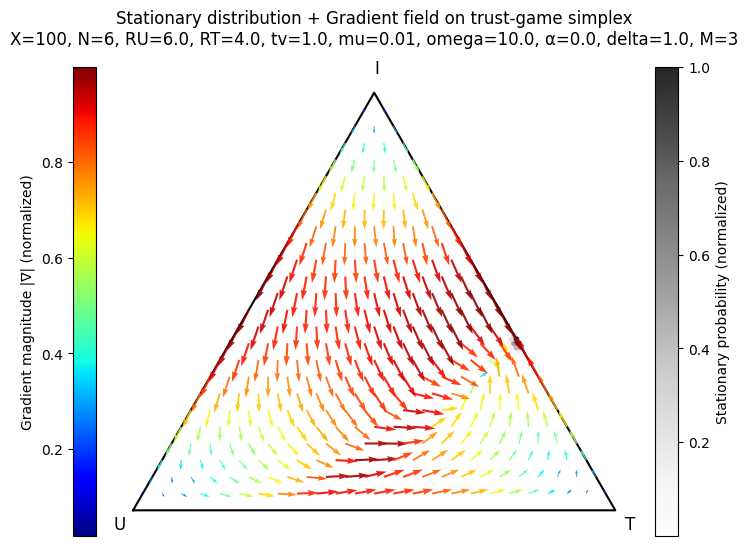

In [53]:
# this template can be used for figure 1 to 3

# Load results
data = np.load("results_part2.npz", allow_pickle=True)
states = data["states"]
x_stat = data["stationary"]
grad_I = data["grad_I"]
grad_T = data["grad_T"]
freq_I = data["freq_I"]
freq_T = data["freq_T"]
freq_U = data["freq_U"]
X = int(data["X"])
params = data["params"].item()

# ---- Simplex mapping (ρ_I, ρ_T, ρ_U → (x,y)) ----
# standard 2-simplex mapping (ρ_I, ρ_T, ρ_U) → (x,y)
# vertices: U=(0,0), T=(1,0), I=(0.5, sqrt(3)/2)
def simplex_to_xy(rI, rT, rU):
    x = rT + 0.5 * rI
    y = (np.sqrt(3)/2) * rI
    return x, y

x_coords, y_coords = simplex_to_xy(freq_I, freq_T, freq_U)

# Stationary distribution scaling
p_norm = x_stat / x_stat.max()

# ---- Gradient vectors ----
dU = -grad_I - grad_T
dx, dy = simplex_to_xy(grad_I, grad_T, dU)
grad_mag = np.sqrt(dx**2 + dy**2) / np.max(np.sqrt(dx**2 + dy**2)) # normalized

# ---- Downsample vector field ----
# define coarse grid spacing
step = 4  
mask = (states[:,0] % step == 0) & (states[:,1] % step == 0)

xs = x_coords[mask]
ys = y_coords[mask]
dxs = dx[mask]
dys = dy[mask]
gmag = grad_mag[mask]

# Normalize arrow length
dxs = dxs / np.max(np.abs(dxs)) * 0.05
dys = dys / np.max(np.abs(dys)) * 0.05

# ---- Figure setup ----
fig, ax = plt.subplots(figsize=(8,7))

# MAIN heatmap (background)
scatter = ax.scatter(
    x_coords, y_coords, 
    c=p_norm, cmap="Greys",
    s=10, alpha=0.85
)

# Right colorbar = stationary distribution
cbar_right = fig.colorbar(scatter, ax=ax, location="right", pad=0.02, shrink=0.7)
cbar_right.set_label("Stationary probability (normalized)")

# ---- Left colorbar = gradient magnitude ----
norm = Normalize(vmin=gmag.min(), vmax=gmag.max())
sm = ScalarMappable(norm=norm, cmap="jet")
cbar_left = fig.colorbar(sm, ax=ax, location="left", pad=0.02, shrink=0.7)
cbar_left.set_label("Gradient magnitude |∇| (normalized)")

# ---- Draw arrows with width proportional to gradient magnitude ----
# We draw arrows in "bins" of gradient magnitude so each bin gets its own width.
bins = 6
edges = np.linspace(gmag.min(), gmag.max(), bins+1)

for i in range(bins):
    lo, hi = edges[i], edges[i+1]
    sel = (gmag >= lo) & (gmag < hi)
    if np.sum(sel) == 0:
        continue
    
    width = 0.001 + 0.003 * (i / (bins - 1))  # varying arrow widths

    ax.quiver(
        xs[sel], ys[sel],
        dxs[sel], dys[sel],
        gmag[sel],
        cmap="jet",
        norm=norm,
        angles="xy",
        scale_units="xy",
        scale=1,
        width=width,
        alpha=0.9,
        zorder=5
    )

# ---- Draw triangle boundary ----
verts = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
ax.plot(verts[:,0], verts[:,1], 'k-', lw=1.5)

ax.text(-0.04, -0.04, "U", fontsize=12)
ax.text(1.02, -0.04, "T", fontsize=12)
ax.text(0.50, np.sqrt(3)/2 + 0.04, "I", fontsize=12)

ax.set_title(
    "Stationary distribution + Gradient field on trust-game simplex\n"
    f"X={X_param}, N={params['N']}, RU={params['RU']}, RT={params['RT']}, tv={params['tv']}, mu={mu_param}, omega={omega_param}, α={params['alpha']}, delta={params['delta']}, M={params['M']}"
    , pad=20
)

ax.set_aspect("equal")
ax.axis("off")

plt.tight_layout()
plt.show()


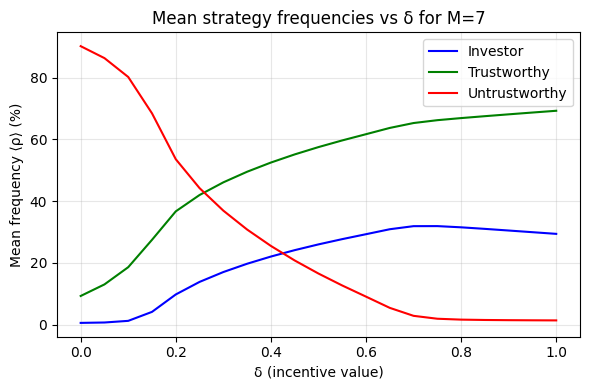

In [59]:
# Fig 4
# Sweep delta and plot mean frequencies (bar or line)

M=7  # or 3, or 7
# Suppose you saved multiple result files: results_delta0.1.npz, results_delta0.2.npz, ...
deltas = [i/20 for i in range(21)]  # 0.0 to 1.0 in steps of 0.05
rhoI_list, rhoT_list, rhoU_list = [], [], []

for d in deltas:
    fname = f"M={M}/delta_{d:.2f}.npz"
    if not os.path.exists(fname):
        fname = f"M={M}/delta_{d:.1f}.npz"
        if not os.path.exists(fname):
            print("missing", fname)
            continue
    data = np.load(fname, allow_pickle=True)
    rhoI_list.append(float(data["mean_rho_I"]))
    rhoT_list.append(float(data["mean_rho_T"]))
    rhoU_list.append(float(data["mean_rho_U"]))

plt.figure(figsize=(6,4))
plt.plot(deltas, np.array(rhoI_list) * 100, color='blue', label='Investor')
plt.plot(deltas, np.array(rhoT_list) * 100, color='green', label='Trustworthy')
plt.plot(deltas, np.array(rhoU_list) * 100, color='red', label='Untrustworthy')
plt.xlabel("δ (incentive value)")
plt.ylabel("Mean frequency ⟨ρ⟩ (%)")
plt.title(f"Mean strategy frequencies vs δ for M={M}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
